In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import torchsde
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

### Increase recursion limit to allow $torchsde.sdeint$ perform deep recursive calls

In [55]:
# Increase recursion limit to handle deeper recursions
import sys
sys.setrecursionlimit(2500)

In [5]:
import sys
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torchsde
from sklearn.preprocessing import MinMaxScaler

# Increase recursion limit to handle deeper recursions
sys.setrecursionlimit(2500)

# Fetch S&P 500 data
data = yf.download('^GSPC', start='2000-01-01', end='2024-01-01')
data = data[['Close']]
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# Prepare data for PyTorch
prices = data['Close'].values
returns = data['Returns'].values
timesteps = torch.linspace(0, len(returns) - 1, len(returns))
data_tensor = torch.tensor(returns, dtype=torch.float32).view(-1, 1)

# Scale the returns for better visualization
scaler = MinMaxScaler(feature_range=(0, 1))
returns_scaled = scaler.fit_transform(returns.reshape(-1, 1)).flatten()

# Define Neural SDE model class
batch_size, state_size, brownian_size = 32, 1, 5  # Set batch_size > 1 for better utilization
t_size = 20

class SDE(nn.Module):
    noise_type = 'general'
    sde_type = 'stratonovich'

    def __init__(self):
        super().__init__()
        self.mu = nn.Linear(state_size, state_size)
        self.sigma = nn.Linear(state_size, state_size * brownian_size)

    # Drift
    def f(self, t, y):
        return self.mu(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(y.size(0), state_size, brownian_size)

# Training configuration
sde = SDE()

# Training loop setup
epochs = 3000  # Number of epochs for training
ts = torch.linspace(0, 1, t_size)

# Define optimizer and loss function
optimizer = torch.optim.Adam(sde.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Initialize variables
best_loss = float('inf')
best_epoch = 0
losses = []  # List to store loss values for each epoch
n_trajectories = 16  # Number of trajectories to average

# Training loop
for epoch in range(epochs):
    # Select random indices for initial states and corresponding future target values
    indices = np.random.choice(len(returns) - t_size, size=batch_size, replace=False)
    y0 = torch.tensor(returns[indices], dtype=torch.float32).view(batch_size, state_size)

    # Set target values to be the returns after t_size steps from the starting points
    future_indices = indices + t_size
    actual_scaled_batch = torch.tensor(returns_scaled[future_indices], dtype=torch.float32).view(batch_size, state_size)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Solve the SDE for n_trajectories and average the predictions
    y_pred_final_avg = torch.zeros_like(y0)
    for _ in range(n_trajectories):
        y_pred = torchsde.sdeint(sde, y0, ts, method='heun')  # Solve SDE
        y_pred_final_avg += y_pred[-1, :, :]  # Accumulate the final predictions

    y_pred_final_avg /= n_trajectories  # Average the predictions

    # Calculate the loss between averaged predictions and actual scaled returns
    loss = loss_fn(y_pred_final_avg, actual_scaled_batch)

    # Backpropagate the loss and update model parameters
    loss.backward()
    optimizer.step()

    # Append the current loss to the list
    losses.append(loss.item())

    # Check if the current loss is the best one
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        
        # Save the model state with the epoch and loss in the filename
        model_filename = f'best_model_epoch_{epoch}_loss_{best_loss:.4f}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': sde.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, model_filename)
        
        print(f"New best model saved at epoch {epoch} with loss {best_loss:.4f} as {model_filename}")

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")

print(f"Training complete. Best model at epoch {best_epoch} with loss {best_loss:.4f}.")

[*********************100%***********************]  1 of 1 completed


New best model saved at epoch 0 with loss 0.9844 as best_model_epoch_0_loss_0.9844.pth
Epoch [0/3000], Loss: 0.9844498634338379
New best model saved at epoch 1 with loss 0.7113 as best_model_epoch_1_loss_0.7113.pth
Epoch [10/3000], Loss: 1.03517484664917
New best model saved at epoch 12 with loss 0.6916 as best_model_epoch_12_loss_0.6916.pth
New best model saved at epoch 13 with loss 0.5798 as best_model_epoch_13_loss_0.5798.pth
New best model saved at epoch 17 with loss 0.5331 as best_model_epoch_17_loss_0.5331.pth
Epoch [20/3000], Loss: 0.7586656212806702
New best model saved at epoch 22 with loss 0.2765 as best_model_epoch_22_loss_0.2765.pth
Epoch [30/3000], Loss: 0.3534572124481201


KeyboardInterrupt: 

# 1. Data Preparation

# a. Fetching S&P 500 closing prices

In [ ]:
# Fetch S&P 500 data
data = yf.download('^GSPC', start='2000-01-01', end='2024-01-01')
data = data[['Close']]
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

## b. Convert Data to Tensors

In [ ]:
# Prepare data for PyTorch
prices = data['Close'].values
returns = data['Returns'].values
timesteps = torch.linspace(0, len(returns) - 1, len(returns))
data_tensor = torch.tensor(returns, dtype=torch.float32).view(-1, 1)

## c. Scaling the returns

In [ ]:
# Scale the returns for better visualization
scaler = MinMaxScaler(feature_range=(0, 1))
returns_scaled = scaler.fit_transform(returns.reshape(-1, 1)).flatten()

# 2. Neural SDE Model Definition

In [ ]:
# Define Neural SDE model class
class SDE(nn.Module):
    noise_type = 'general'
    sde_type = 'stratonovich'

    def __init__(self):
        super().__init__()
        self.mu = nn.Linear(state_size, state_size)
        self.sigma = nn.Linear(state_size, state_size * brownian_size)

    # Drift
    def f(self, t, y):
        return self.mu(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(y.size(0), state_size, brownian_size)

## 3. Training Configuration 

In [ ]:
# Training configuration
batch_size, state_size, brownian_size = 32, 1, 5
t_size = 20

# Creating a new SDE object
sde = SDE()

# Training loop setup
epochs = 3000  # Number of epochs for training
ts = torch.linspace(0, 1, t_size)

# Define optimizer and loss function
optimizer = torch.optim.Adam(sde.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

## 4. Training Process

In [57]:
# Initialize variables
best_loss = float('inf')
best_epoch = 0
losses = []  # List to store loss values for each epoch

# Training loop
for epoch in range(epochs):
####################################[ PART 4 - a. Batch Sampling]##########################################################################################

    # Select random indices for initial states and corresponding future target values
    indices = np.random.choice(len(returns) - t_size, size=batch_size, replace=False)  # Ensure enough space for future points
    y0 = torch.tensor(returns[indices], dtype=torch.float32).view(batch_size, state_size)

    # Set target values to be the returns after t_size steps from the starting points
    future_indices = indices + t_size
    actual_scaled_batch = torch.tensor(returns_scaled[future_indices], dtype=torch.float32).view(batch_size, state_size)
####################################[ PART 4 - b. Solving SDE]##########################################################################################

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Solve the SDE for the current model parameters
    y_pred = torchsde.sdeint(sde, y0, ts, method='heun')

    # Use the final prediction for loss calculation
    y_pred_final = y_pred[-1, :, :]  # Final predictions for all elements in the batch

    # Calculate the loss between predicted and actual scaled returns (for training purposes)
    loss = loss_fn(y_pred_final, actual_scaled_batch)

    # Backpropagate the loss and update model parameters
    loss.backward()
    optimizer.step()
####################################[ PART 4 - c. Checkpoint]##########################################################################################
    
    # Append the current loss to the list
    losses.append(loss.item())

    # Check if the current loss is the best one
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        
        # Save the model state with the epoch and loss in the filename
        model_filename = f'best_model_epoch_{epoch}_loss_{best_loss:.4f}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': sde.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, model_filename)
        
        print(f"New best model saved at epoch {epoch} with loss {best_loss:.4f} as {model_filename}")

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")

New best model saved at epoch 0 with loss 0.0129 as best_model_epoch_0_loss_0.0129.pth
Epoch [0/3000], Loss: 0.01289397943764925
New best model saved at epoch 1 with loss 0.0068 as best_model_epoch_1_loss_0.0068.pth


KeyboardInterrupt: 

In [ ]:
print(f"Best epoch was saved as:{model_filename}")

# Save the losses to a file
with open('losses.txt', 'r') as f:
    for loss in losses:
        f.write(f"{loss}\n")

### Best model file name

In [60]:
model_filename = 'best_model_epoch_2971_loss_0.0032.pth'
best_epoch = torch.load(model_filename)

C:\Users\user\AppData\Local\Temp\ipykernel_3248\561979534.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_epoch = torch.load(model_filename)


# 5. Outputs

## a. Training Loss 

Best epoch was saved as:best_model_epoch_2971_loss_0.0032.pth


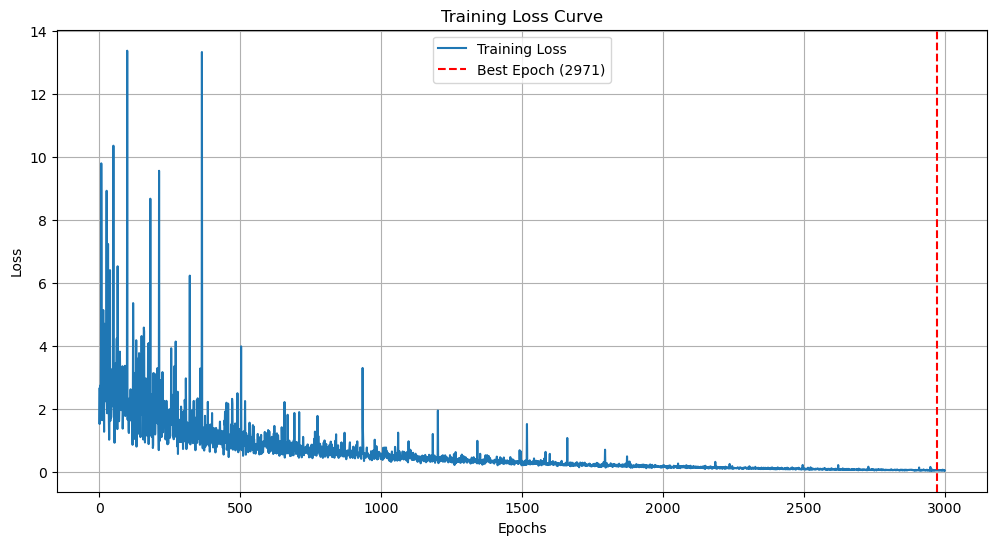

In [37]:
print(f"Best epoch was saved as:{model_filename}")

# Save the losses to a file
with open('losses.txt', 'w') as f:
    for loss in losses:
        f.write(f"{loss}\n")

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.axvline(best_epoch['epoch'], color='red', linestyle='--', label=f'Best Epoch ({best_epoch['epoch']})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.show()

## b. Predictions on Unseen Data

C:\Users\user\AppData\Local\Temp\ipykernel_3248\1788115625.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_filename)
[********************

Loaded model from epoch 2971 with best loss 0.0032
Mean Squared Error on Test Data: 0.0003


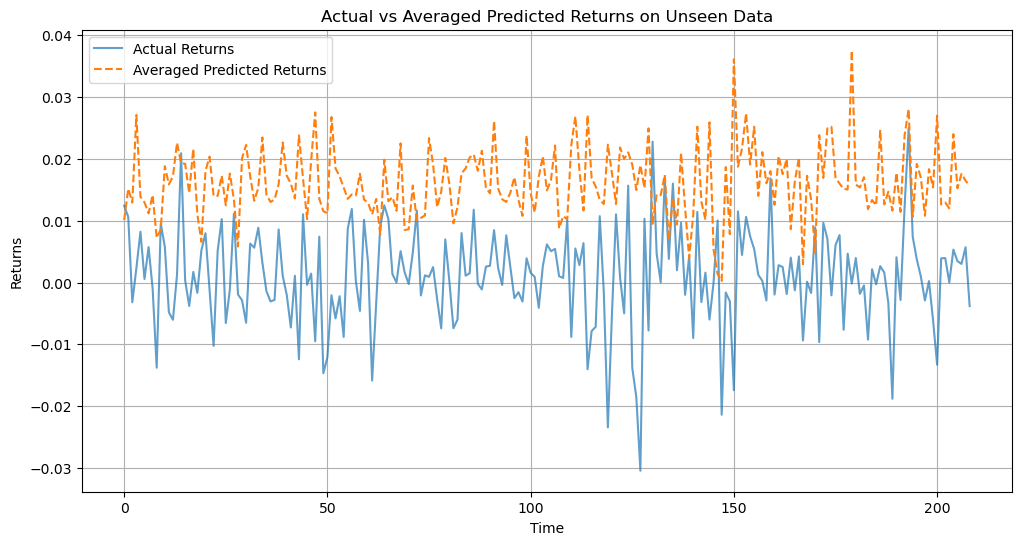

In [61]:
# Load the best trained model
checkpoint = torch.load(model_filename)
sde.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with best loss {checkpoint['loss']:.4f}")

# Fetch unseen S&P 500 data (test set)
test_data = yf.download('^GSPC', start='2024-01-01', end='2024-11-29')
test_data = test_data[['Close']]
test_data['Returns'] = np.log(test_data['Close'] / test_data['Close'].shift(1))
test_data.dropna(inplace=True)

# Prepare test data
test_returns = test_data['Returns'].values
scaler = MinMaxScaler(feature_range=(0, 1))  # Assuming scaler is refitted here or reused from training.
test_returns_scaled = scaler.fit_transform(test_returns.reshape(-1, 1)).flatten()  # Flatten for processing

# Set up batch size for testing
batch_size = 32  # Testing with batch size = 32
t_size_test = min(20, len(test_returns))  # Adjust time steps if there aren't enough data points

# Time steps for testing
ts_test = torch.linspace(0, 1, t_size_test)

# Generate multiple prediction paths on the test data using batch processing
all_predictions = []
num_paths = 10  # Number of prediction paths to generate

with torch.no_grad():
    # Iterate over the test data with batch processing
    for i in range(0, len(test_returns) - t_size_test, batch_size):
        # Ensure not to exceed the length of test_returns
        end_index = min(i + batch_size, len(test_returns) - t_size_test)
        actual_batch_size = end_index - i

        # Set initial states for the current batch
        y0_batch = torch.tensor(test_returns_scaled[i:end_index], dtype=torch.float32).view(actual_batch_size, 1)

        # Generate multiple paths and average the predictions
        batch_predictions = []
        for _ in range(num_paths):
            y_pred = torchsde.sdeint(sde, y0_batch, ts_test, method='heun')
            y_pred_final = y_pred[-1, :, :].view(actual_batch_size, 1).numpy()
            batch_predictions.append(y_pred_final)

        # Average the predictions over all generated paths
        batch_predictions_avg = np.mean(batch_predictions, axis=0)

        # Store the averaged predictions for the current batch
        all_predictions.append(batch_predictions_avg)

# Concatenate all batch predictions into a single array
all_predictions = np.vstack(all_predictions)  # Shape will be (total_batches * batch_size, 1)

# Rescale predictions back to the original scale
all_predictions_rescaled = scaler.inverse_transform(all_predictions)

# Adjust the test returns for comparison, aligning with the number of predictions
test_returns_actual = test_returns[t_size_test:t_size_test + len(all_predictions)]

# Compute Mean Squared Error (MSE) on the test data
mse = np.mean((test_returns_actual - all_predictions_rescaled.flatten())**2)
print(f"Mean Squared Error on Test Data: {mse:.4f}")

# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Plot actual returns
plt.plot(test_returns_actual, label='Actual Returns', alpha=0.7)

# Plot averaged predicted returns
plt.plot(all_predictions_rescaled.flatten(), label='Averaged Predicted Returns', linestyle='--')

# Add labels, title, legend, and grid
plt.legend()
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Actual vs Averaged Predicted Returns on Unseen Data')
plt.grid()

# Show the plot
plt.show()


# 6. Model Calibration

## a. Online Training. 

In [48]:
num_paths = 10  # Number of prediction paths to average

# Online retraining loop
for i in range(len(test_returns_scaled) - 1):  # Step through data one point at a time
    # Get the current unseen data point
    current_point = test_returns_scaled[i]
    next_point = test_returns_scaled[i + 1]  # The target value is the next data point in the sequence

    # Initialize the current state
    y0_online = torch.tensor([[current_point]], dtype=torch.float32, requires_grad=True)  # Single point as input

    # Generate multiple prediction paths and average them
    path_predictions = []
    for _ in range(num_paths):
        ts_online = torch.tensor([0.0, 1.0])  # Two timesteps for prediction
        y_pred = torchsde.sdeint(sde, y0_online, ts_online, method='heun')[-1, :, :]
        path_predictions.append(y_pred.item())
    avg_prediction = np.mean(path_predictions)

    # Store the averaged prediction
    predictions.append(avg_prediction)

    # Compute loss
    target = torch.tensor([[next_point]], dtype=torch.float32)
    avg_prediction_tensor = torch.tensor([[avg_prediction]], dtype=torch.float32, requires_grad=True)
    loss = loss_fn(avg_prediction_tensor, target)
    online_losses.append(loss.item())

    # Backpropagate and update model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress every 100 steps
    if i % 100 == 0:
        print(f"Step {i}/{len(test_returns_scaled)}, Loss: {loss.item():.4f}")

C:\Users\user\AppData\Local\Temp\ipykernel_3248\1644187030.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_filename)
[********************

Loaded model from epoch 2971 with best loss 0.0032
Step 0/229, Loss: 0.0992
Step 100/229, Loss: 0.2283
Step 200/229, Loss: 0.0917


In [49]:
# Rescale predictions back to the original scale
predictions_scaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Compute final MSE on unseen data
test_returns_actual = test_returns[1:len(predictions_scaled) + 1]  # Align with predictions
mse_online = np.mean((test_returns_actual - predictions_scaled) ** 2)
print(f"Mean Squared Error on Unseen Data (After Online Retraining): {mse_online:.4f}")

Mean Squared Error on Unseen Data (After Online Retraining): 0.0003


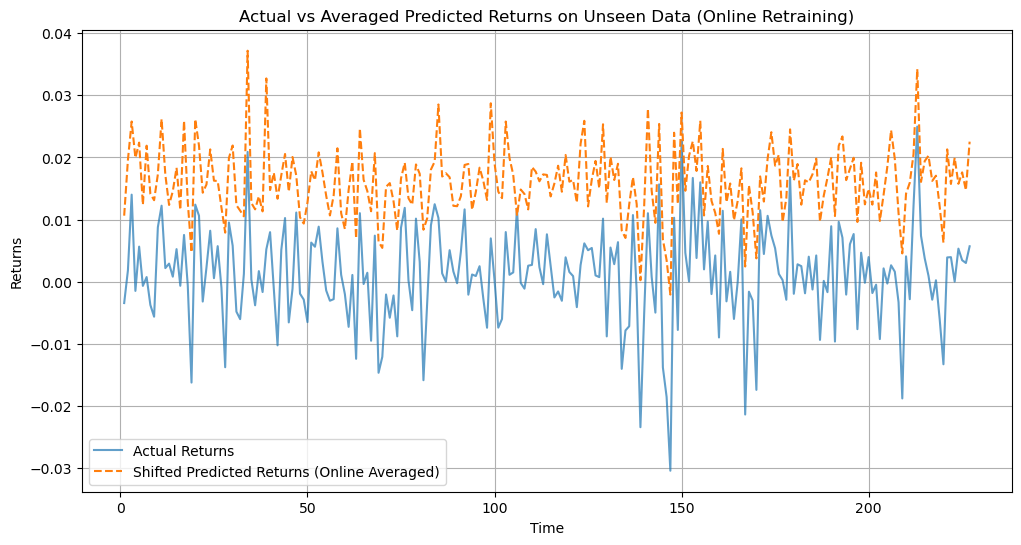

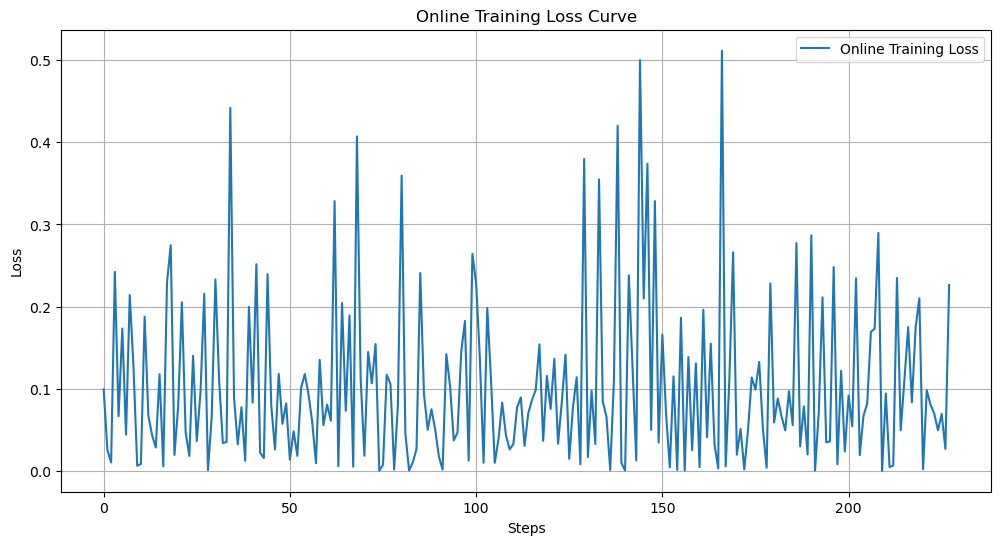

In [51]:
# Shift the predictions by 1 timestep
shifted_predictions = np.roll(predictions_scaled, shift=-1)

shifted_preds_returns = shifted_predictions[:-1]
shifted_actual_returns = test_returns_actual[:-1]

# Plot actual vs predicted returns
plt.figure(figsize=(12, 6))
plt.plot(test_timesteps.numpy()[1:len(shifted_actual_returns)+1], shifted_actual_returns, label='Actual Returns', alpha=0.7)
plt.plot(test_timesteps.numpy()[1:len(shifted_preds_returns)+1], shifted_preds_returns, label='Shifted Predicted Returns (Online Averaged)', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Actual vs Averaged Predicted Returns on Unseen Data (Online Retraining)')
plt.grid()
plt.show()

# Plot online training loss
plt.figure(figsize=(12, 6))
plt.plot(range(len(online_losses)), online_losses, label='Online Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Online Training Loss Curve')
plt.legend()
plt.grid()
plt.show()


## b. Stacking: Find a mapping $f$ :  $predictions \xrightarrow{f} actual$

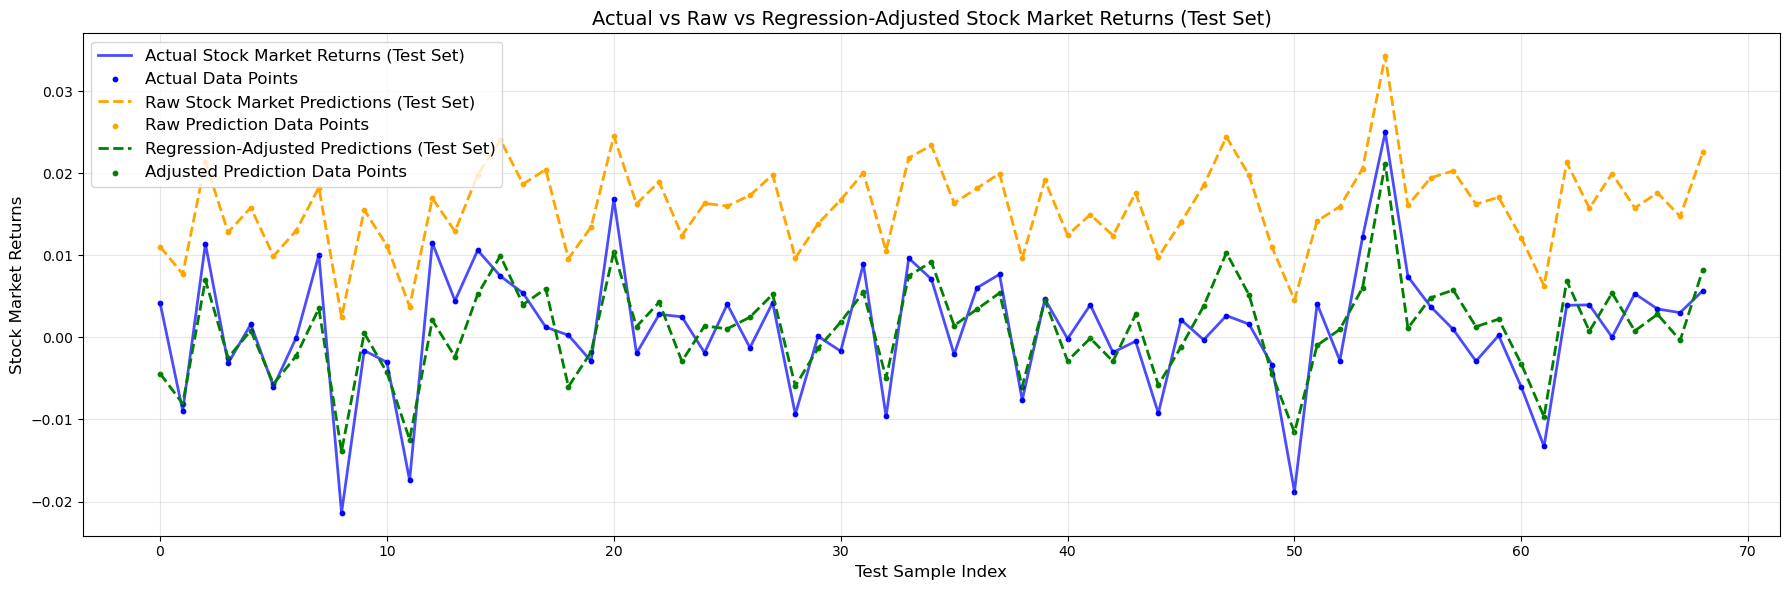

In [54]:
from sklearn.linear_model import LinearRegression
# Shift the predictions to the left by one
shifted_predictions = np.roll(predictions_scaled, -1)

# Align predictions and actual returns for analysis
shifted_preds_returns = shifted_predictions[:-1]
shifted_actual_returns = test_returns_actual[:-1]

# Define split for validation and test sets
N = len(shifted_preds_returns)
validation_split = int(0.7 * N)  # 60% for validation, 40% for testing

# Split the data into validation and test sets

# Validation set
X_validation = shifted_preds_returns[:validation_split].reshape(-1, 1)
y_validation = shifted_actual_returns[:validation_split]

# Test set
X_test = shifted_preds_returns[validation_split:].reshape(-1, 1)
y_test_actual = shifted_actual_returns[validation_split:]

# Train the regression model on the validation set
reg_model = LinearRegression()
reg_model.fit(X_validation, y_validation)

# Predict actual returns for the test set
predicted_test_returns = reg_model.predict(X_test)

# Plot Actual, Raw Predictions, and Regression-Adjusted Predictions for the test set
plt.figure(figsize=(18, 6))

# Actual Returns
plt.plot(range(len(y_test_actual)), y_test_actual, 
         label='Actual Stock Market Returns (Test Set)', color='blue', alpha=0.7, linewidth=2)
plt.scatter(range(len(y_test_actual)), y_test_actual, 
            color='blue', s=10, label='Actual Data Points')  # Adding dots

# Raw Predictions
plt.plot(range(len(shifted_preds_returns[validation_split:])), shifted_preds_returns[validation_split:], 
         label='Raw Stock Market Predictions (Test Set)', color='orange', linestyle='--', linewidth=2)
plt.scatter(range(len(shifted_preds_returns[validation_split:])), shifted_preds_returns[validation_split:], 
            color='orange', s=10, label='Raw Prediction Data Points')  # Adding dots

# Regression-Adjusted Predictions
plt.plot(range(len(predicted_test_returns)), predicted_test_returns, 
         label='Regression-Adjusted Predictions (Test Set)', color='green', linestyle='--', linewidth=2)
plt.scatter(range(len(predicted_test_returns)), predicted_test_returns, 
            color='green', s=10, label='Adjusted Prediction Data Points')  # Adding dots

# Enhance plot appearance
plt.legend(fontsize=12)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Stock Market Returns', fontsize=12)
plt.title('Actual vs Raw vs Regression-Adjusted Stock Market Returns (Test Set)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## $preds \xrightarrow{f} [preds-actual]$

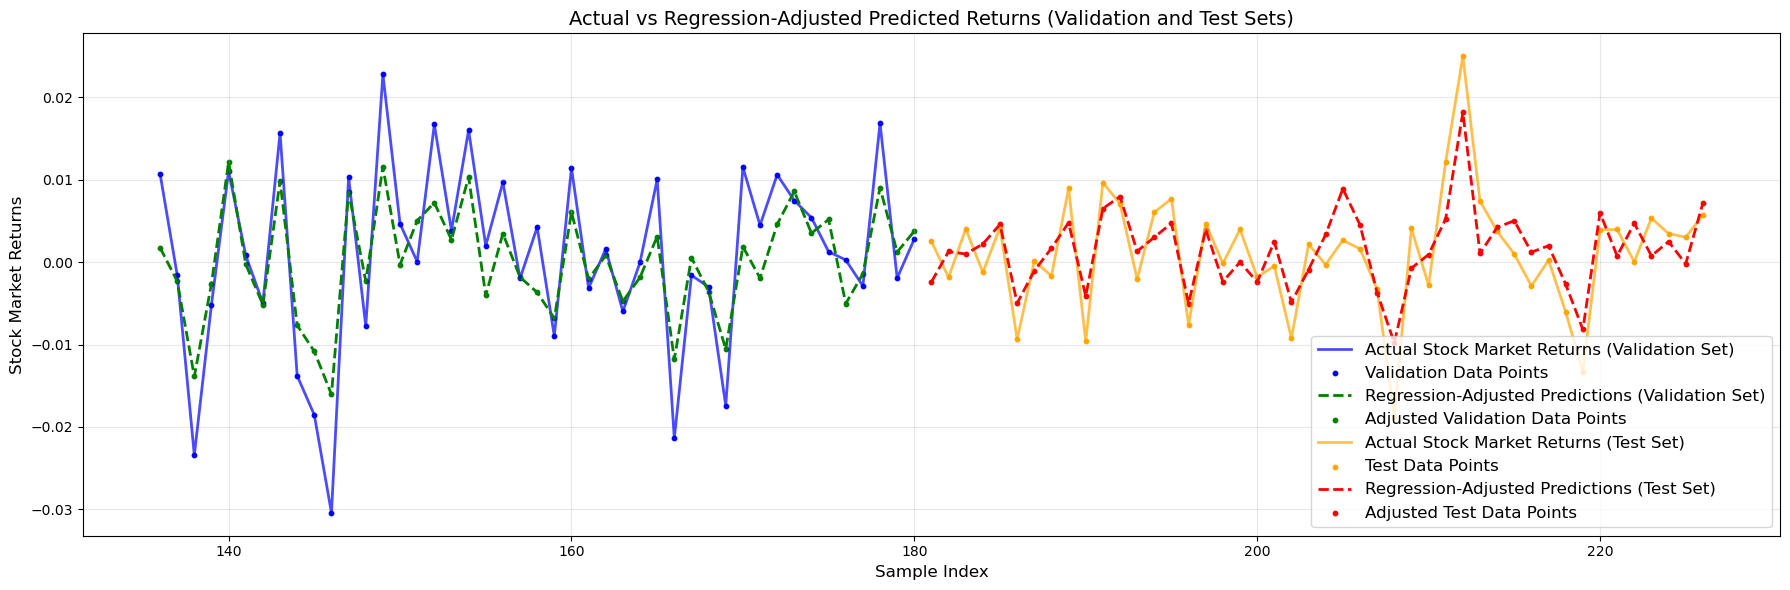

In [56]:
# Shift the predictions to the left by one
# Align predictions and actual returns for analysis
shifted_preds_returns = shifted_predictions[:-1]
shifted_actual_returns = test_returns_actual[:-1]

# Define split for training, validation, and test sets
N = len(shifted_preds_returns)
train_split = int(0.6 * N)  # 60% for training
validation_split = int(0.8 * N)  # Next 20% for validation

# Split the data into training, validation, and test sets
X_train = shifted_preds_returns[:train_split].reshape(-1, 1)
y_train = shifted_actual_returns[:train_split] - shifted_preds_returns[:train_split]

X_validation = shifted_preds_returns[train_split:validation_split].reshape(-1, 1)
y_validation = shifted_actual_returns[train_split:validation_split]

X_test = shifted_preds_returns[validation_split:].reshape(-1, 1)
y_test_actual = shifted_actual_returns[validation_split:]
shifted_predictions_test = shifted_preds_returns[validation_split:]

# Train the regression model on the training set
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predict differences for validation and test sets
predicted_differences_validation = reg_model.predict(X_validation)
adjusted_predictions_validation = shifted_preds_returns[train_split:validation_split] + predicted_differences_validation

predicted_differences_test = reg_model.predict(X_test)
adjusted_predictions_test = shifted_predictions_test + predicted_differences_test


# Plot Actual, Raw Predictions, and Regression-Adjusted Predictions for validation and test sets
plt.figure(figsize=(18, 6))

# Actual Returns (Validation)
plt.plot(range(train_split, validation_split), y_validation, 
         label='Actual Stock Market Returns (Validation Set)', color='blue', alpha=0.7, linewidth=2)
plt.scatter(range(train_split, validation_split), y_validation, 
            color='blue', s=10, label='Validation Data Points')  # Adding dots

# Adjusted Predictions (Validation)
plt.plot(range(train_split, validation_split), adjusted_predictions_validation, 
         label='Regression-Adjusted Predictions (Validation Set)', color='green', linestyle='--', linewidth=2)
plt.scatter(range(train_split, validation_split), adjusted_predictions_validation, 
            color='green', s=10, label='Adjusted Validation Data Points')  # Adding dots

# Actual Returns (Test)
plt.plot(range(validation_split, N), y_test_actual, 
         label='Actual Stock Market Returns (Test Set)', color='orange', alpha=0.7, linewidth=2)
plt.scatter(range(validation_split, N), y_test_actual, 
            color='orange', s=10, label='Test Data Points')  # Adding dots

# Adjusted Predictions (Test)
plt.plot(range(validation_split, N), adjusted_predictions_test, 
         label='Regression-Adjusted Predictions (Test Set)', color='red', linestyle='--', linewidth=2)
plt.scatter(range(validation_split, N), adjusted_predictions_test, 
            color='red', s=10, label='Adjusted Test Data Points')  # Adding dots

# Enhance plot appearance
plt.legend(fontsize=12)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Stock Market Returns', fontsize=12)
plt.title('Actual vs Regression-Adjusted Predicted Returns (Validation and Test Sets)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
